In [0]:
from vowpalwabbit import pyvw
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools

In [0]:
# VW tries to minimize loss/cost, therefore we will pass cost as -reward
USER_LIKED_ARTICLE = -1.0
USER_DISLIKED_ARTICLE = 0.0

In [0]:
def get_cost(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'music':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'politics':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

In [0]:
# This function modifies (context, action, cost, probability) to VW friendly format
def to_vw_example_format(context, actions, cb_label = None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    example_string += "shared |User user={} time_of_day={}\n".format(context["user"], context["time_of_day"])
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action article={} \n".format(action)
    #Strip the last newline
    return example_string[:-1]

In [5]:
context = {"user":"Tom","time_of_day":"morning"}
actions = ["politics", "sports", "music", "food"]

print(to_vw_example_format(context,actions))

shared |User user=Tom time_of_day=morning
|Action article=politics 
|Action article=sports 
|Action article=music 
|Action article=food 


In [0]:
def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1/total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index, prob

In [0]:
def get_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context,actions)
    pmf = vw.predict(vw_text_example)
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return actions[chosen_action_index], prob

In [8]:
users = ['Tom', 'Anna']
times_of_day = ['morning', 'afternoon']
actions = ["politics", "sports", "music", "food", "finance", "health", "camping"]

def choose_user(users):
    return random.choice(users)

def choose_time_of_day(times_of_day):
    return random.choice(times_of_day)

# display preference matrix
def get_preference_matrix(cost_fun):
    def expand_grid(data_dict):
        rows = itertools.product(*data_dict.values())
        return pd.DataFrame.from_records(rows, columns=data_dict.keys())

    df = expand_grid({'users':users, 'times_of_day': times_of_day, 'actions': actions})
    df['cost'] = df.apply(lambda r: cost_fun({'user': r[0], 'time_of_day': r[1]}, r[2]), axis=1)

    return df.pivot_table(index=['users', 'times_of_day'], 
            columns='actions', 
            values='cost')

get_preference_matrix(get_cost)

actions             camping  finance  food  health  music  politics  sports
users times_of_day                                                         
Anna  afternoon         0.0      0.0   0.0     0.0    0.0      -1.0     0.0
      morning           0.0      0.0   0.0     0.0    0.0       0.0    -1.0
Tom   afternoon         0.0      0.0   0.0     0.0   -1.0       0.0     0.0
      morning           0.0      0.0   0.0     0.0    0.0      -1.0     0.0

In [0]:
def run_simulation(vw, num_iterations, users, times_of_day, actions, cost_function, do_learn = True):
    cost_sum = 0.
    ctr = []

    for i in range(1, num_iterations+1):
        # 1. In each simulation choose a user
        user = choose_user(users)
        # 2. Choose time of day for a given user
        time_of_day = choose_time_of_day(times_of_day)

        # 3. Pass context to vw to get an action
        context = {'user': user, 'time_of_day': time_of_day}
        action, prob = get_action(vw, context, actions)

        # 4. Get cost of the action we chose
        cost = cost_function(context, action)
        cost_sum += cost

        if do_learn:
            # 5. Inform VW of what happened so we can learn from it
            vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
            # 6. Learn
            vw.learn(vw_format)

        # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
        ctr.append(-1*cost_sum/i)

    return ctr

In [0]:
def plot_ctr(num_iterations, ctrs, fixed_epsilon=True, labels = ["e = {}".format(e/10) for e in range(0, 11, 1)]):
    plt.figure(figsize=[15,7])
    # For same value of epsilon 
    if fixed_epsilon:
        plt.plot(range(1,num_iterations+1), ctrs)
        plt.legend(["e = 0.2"], loc='best',  bbox_to_anchor=(1.1,1))
    # For different values of epsilon
    else:
      #  labels = ["e = {}".format(e/10) for e in range(0, 11, 1)]
        [plt.plot(range(1,num_iterations+1), ctr, label = label) for ctr, label in zip(ctrs, labels)]
        plt.legend(loc='best',  bbox_to_anchor=(1.1,1))
        
    plt.xlabel('num_iterations', fontsize=14)
    plt.ylabel('ctr', fontsize=14)
    plt.ylim([0,1])

In [0]:
def plotbox_hyperparameters(algorithm, hyperparameter, num_iterations = 5000):
  ctrs = {}
  final_ctrs = []
  seeds = [1,4,3,6,33,23]
# Instantiate learner in VW for different values of epsilon from 0 to 1 in 0.1 increments
  for parameter in hyperparameter[1]:

    ctrs[parameter] = []
    final_parameter = []
    for seed in seeds:
      vw = pyvw.vw("--cb_explore_adf -q UA --quiet --random_seed {} ".format(seed) + hyperparameter[0] + " {}".format(parameter))
      ctrs[parameter].append(run_simulation(vw, num_iterations, users, times_of_day, actions, get_cost))
    

    
    for ctr in ctrs[parameter]:
      final_parameter.append(ctr[-1])
    final_ctrs.append(final_parameter)
#  print(final_ctrs)
  from matplotlib import pyplot
  plt.figure(figsize=[15,7])
  pyplot.boxplot(final_ctrs)
  plt.xticks(list(range(1, len(hyperparameter[1])+1, 1)), [hyperparameter[0].split('--')[-1]+" = {}".format(e) for e in hyperparameter[1]])
  pyplot.title("Hyperparameter Comparison " + algorithm)
  pyplot.show()
  return ctrs

In [0]:
algorithms = ['bag', 'cover', 'greedy', 'first', 'regcb', 'softmax']
hyperparameters = {}
hyperparameters['greedy'] = ['--epsilon', [e/10 for e in range(0, 11, 1)]]
hyperparameters['first'] = ['--first', [2**n for n in range(0, 11, 1)]]
hyperparameters['bag'] = ['--bag', [2*n + 1 for n in range(0, 4, 1)]]
hyperparameters['cover'] = ['--cover', [2*n + 1 for n in range(0, 4, 1)]]
hyperparameters['softmax'] = ['--softmax --lambda', [0, 0.1, 1, 10, 50]]
hyperparameters['regcb'] = ['--regcb --mellowness', [0.001, 0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10]]

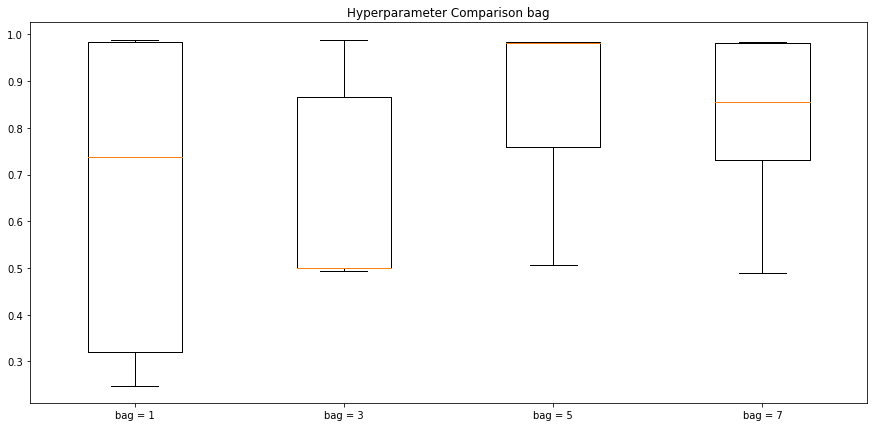

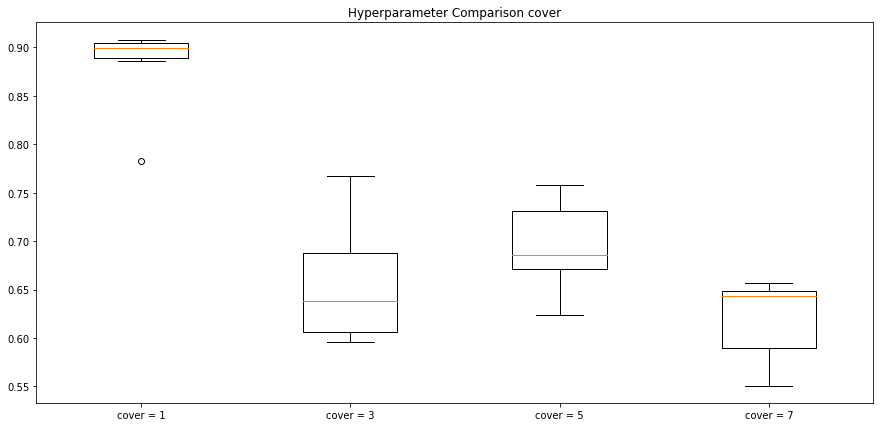

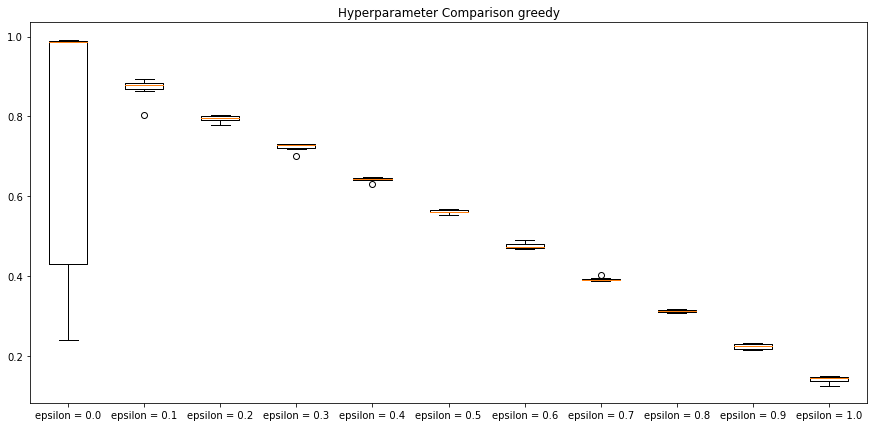

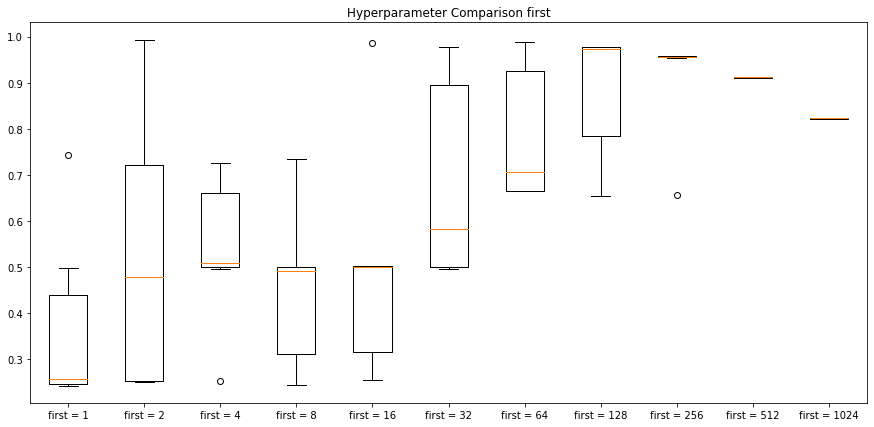

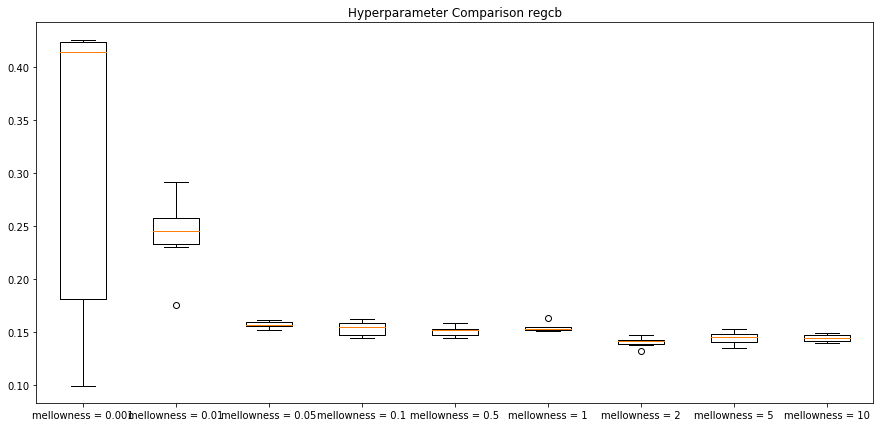

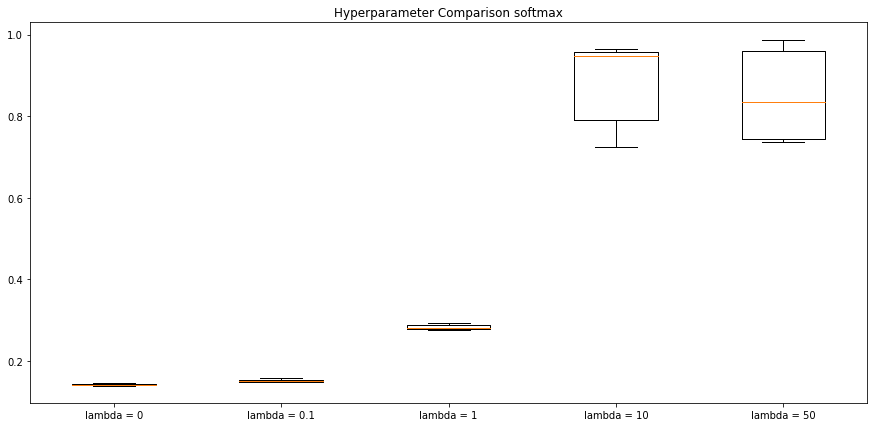

In [13]:
ctrs_algorithm = {}
for algorithm in algorithms:
  ctrs_algorithm[algorithm] = plotbox_hyperparameters(algorithm, hyperparameters[algorithm], num_iterations=5000)

In [0]:
# On the basis of box plot cosidering the best hyperameter
hyperparameters['greedy'].append(0.1)
hyperparameters['first'].append(128)
hyperparameters['bag'].append(1)
hyperparameters['cover'].append(1)
hyperparameters['softmax'].append(10)
hyperparameters['regcb'].append(0.001)


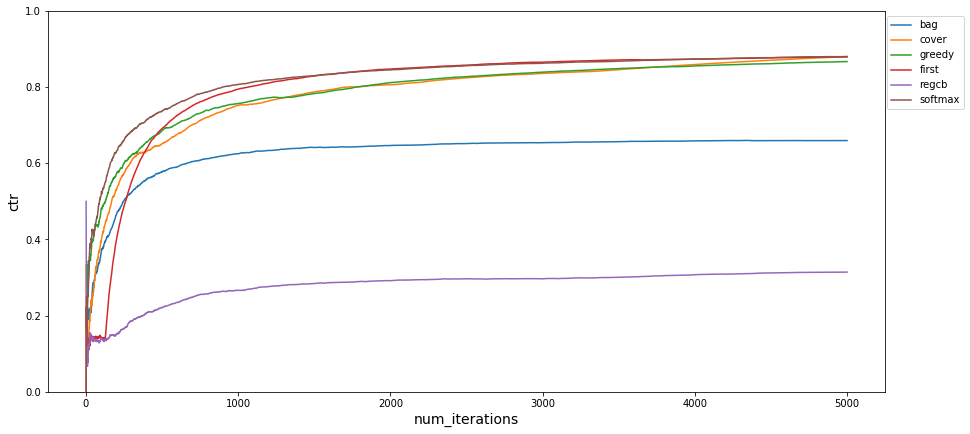

In [18]:
best_ctrs = []
num_iterations=5000
for algorithm in algorithms:
   # ctrs_algorithm[algorithm][hyperparameters[algorithm][2]]
    best_ctrs.append(ctrs_algorithm[algorithm][hyperparameters[algorithm][2]])

plot_ctr(num_iterations, np.mean(best_ctrs, axis=1), fixed_epsilon=False, labels = algorithms)